In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='winter')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda'
torch.cuda.is_available()

True

In [4]:
with open('../dataset/cleaned_text.txt', encoding='utf-8') as f:
    data = f.read()

In [5]:
data[:100]

'птичка в чужбине свято наблюдаю родной обычай старины: на волю птичку выпускаю при светлом празднике'

In [6]:
sents = []
for sent in tqdm(sent_tokenize(data, language='russian'), desc='loading'):
    if 16 < len(sent) < 128:
        sents.append(sent.lower())

loading:   0%|          | 0/84536 [00:00<?, ?it/s]

In [7]:
len(sents)

59288

In [8]:
sents[100:104]

['душа моя хранит ли образ незабвенный?',
 'любви блаженство знал ли я?',
 'тоскою ль долгой изнуренный, таил я слезы в тишине?',
 'где та была, которой очи, как небо, улыбались мне?']

In [9]:
chars = Counter()


In [10]:
for sent in tqdm(sents):
    for c in sent:
        chars[c] += 1

  0%|          | 0/59288 [00:00<?, ?it/s]

In [11]:
len(chars)

108

In [12]:
chars

Counter({' ': 511795,
         'о': 286323,
         'е': 238281,
         'а': 233654,
         'и': 195539,
         'н': 181790,
         'т': 152681,
         'с': 150046,
         'л': 135185,
         'в': 132437,
         'р': 129913,
         'к': 92419,
         'м': 91324,
         'д': 87396,
         'у': 82584,
         'п': 78544,
         'я': 61938,
         '.': 56378,
         ',': 55169,
         'г': 54743,
         'ь': 52814,
         'ы': 51690,
         'б': 50999,
         'з': 47115,
         'ч': 39714,
         'й': 35592,
         'ж': 27526,
         'ш': 25452,
         'х': 23511,
         'ю': 19019,
         '-': 18294,
         '"': 13592,
         'ц': 13306,
         'e': 7716,
         'щ': 7242,
         'i': 5676,
         '?': 5618,
         'ф': 4744,
         ';': 4718,
         'э': 4597,
         '!': 4522,
         ':': 4397,
         '1': 4193,
         ')': 4055,
         'a': 3866,
         's': 3548,
         'n': 3310,
         't': 32

In [13]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
cnt_threshold = 4550

for c, cnt in chars.items():
    if cnt > cnt_threshold:
        vocab.add(c)
    

In [14]:
len(vocab)

44

In [15]:
c2id = {c: i for i, c in enumerate(vocab)}
id2c = {i: c for c, i in c2id.items()}


In [16]:
c2id

{'х': 0,
 ' ': 1,
 'о': 2,
 'ю': 3,
 'ц': 4,
 'б': 5,
 ',': 6,
 '"': 7,
 'т': 8,
 'э': 9,
 'e': 10,
 '<unk>': 11,
 'ш': 12,
 'д': 13,
 '<bos>': 14,
 'й': 15,
 'п': 16,
 'ь': 17,
 '?': 18,
 ';': 19,
 'с': 20,
 'ч': 21,
 '.': 22,
 'щ': 23,
 'ж': 24,
 'и': 25,
 '-': 26,
 'з': 27,
 'к': 28,
 'а': 29,
 'м': 30,
 'i': 31,
 'р': 32,
 'г': 33,
 '<pad>': 34,
 '<eos>': 35,
 'в': 36,
 'л': 37,
 'я': 38,
 'у': 39,
 'н': 40,
 'ы': 41,
 'е': 42,
 'ф': 43}

In [17]:
class CharDataset:
    def __init__(self, sents):
        self.data = sents
        self.unk_id = c2id['<unk>']
        self.bos_id = c2id['<bos>']
        self.eos_id = c2id['<eos>']
        self.pad_id = c2id['<pad>']
    
    def __getitem__(self, idx):
        token_s = [self.bos_id]
        token_s += [c2id.get(c, self.unk_id) for c in self.data[idx]]
        token_s += [self.eos_id]
        return token_s

    def __len__(self):
        return len(self.data)

In [18]:
def trans_func(input_batch, pad_id=c2id['<pad>']):
    s_lens = [len(x) for x in input_batch]
    max_s_len = max(s_lens)
    new_batch = []
    for s in input_batch:
        for _ in range(max_s_len - len(s)):
            s.append(pad_id)
        new_batch.append(s)
    sq = torch.LongTensor(new_batch).to(device)
    new_batch = {
        'in_ids': sq[:, :-1], 
        'target_ids': sq[:, 1:],
    }
    return new_batch
        
    
    

In [19]:
batch = [[1, 2, 3, 4, 5, 6, 7], [3, 4, 5, 6], [345, 3, 5]]

trans_func(batch)

{'in_ids': tensor([[  1,   2,   3,   4,   5,   6],
         [  3,   4,   5,   6,  34,  34],
         [345,   3,   5,  34,  34,  34]], device='cuda:0'),
 'target_ids': tensor([[ 2,  3,  4,  5,  6,  7],
         [ 4,  5,  6, 34, 34, 34],
         [ 3,  5, 34, 34, 34, 34]], device='cuda:0')}

In [20]:
train_s, eval_s = train_test_split(sents, test_size=0.2)

In [21]:
len(train_s), len(eval_s)

(47430, 11858)

In [22]:
train_dataset = CharDataset(train_s)
eval_dataset = CharDataset(eval_s)

In [23]:
train_dataloader = DataLoader(
    train_dataset, collate_fn=trans_func, batch_size=128,
)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=trans_func, batch_size=128,
)

In [24]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0)
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)  # batch_sz, sq_len, hidden_dim
        out, _ = self.rnn(embeddings) # batch_sz, sq_len, hidden_dim
        out = self.dropout(self.linear(self.non_lin(out)))  # batch_sz, sq_len, hidden_dim
        res = self.linear2(self.non_lin(out))  # batch_sz, sq_len, vocab_size

        return res
        

In [25]:
def evaluate(mode, crit):
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logs = model(batch['in_ids']).flatten(start_dim=0, end_dim=1)
            loss = crit(
                logs, 
                batch['target_ids'].flatten(),
            )
            perplexity.append(torch.exp(loss).item())
        perplexity = sum(perplexity) / len(perplexity)
        return perplexity

In [26]:
model = CharLM(hidden_dim=300, vocab_size=len(vocab), num_layers=2).to(device)

In [27]:
crit = nn.CrossEntropyLoss(ignore_index=c2id['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [28]:
num_eps = 50
losses = []
perplexities = []

for ep in range(num_eps):
    ep_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'epoch {ep + 1}'):
        optimizer.zero_grad()
        logs = model(batch['in_ids']).flatten(start_dim=0, end_dim=1)
        loss = crit(
            logs, batch['target_ids'].flatten()
        )
        loss.backward()
        optimizer.step()

        ep_losses.append(loss.item())
    losses.append(sum(ep_losses) / len(ep_losses))
    perplexities.append(evaluate(model, crit))
    

epoch 1:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 6:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 7:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 8:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 9:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 10:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 11:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 12:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 13:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 14:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 15:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 16:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 17:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 18:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 19:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 20:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 21:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 22:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 23:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 24:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 25:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 26:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 27:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 28:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 29:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 30:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 31:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 32:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 33:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 34:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 35:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 36:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 37:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 38:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 39:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 40:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 41:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 42:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 43:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 44:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 45:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 46:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 47:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 48:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 49:   0%|          | 0/371 [00:00<?, ?it/s]

epoch 50:   0%|          | 0/371 [00:00<?, ?it/s]

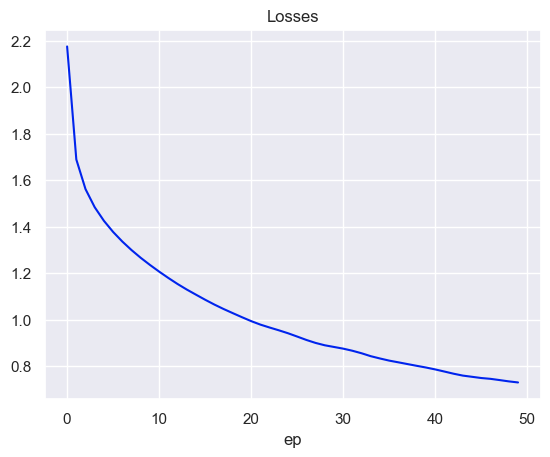

In [29]:
plt.plot(losses)
plt.title('Losses')
plt.xlabel('ep')
plt.show()

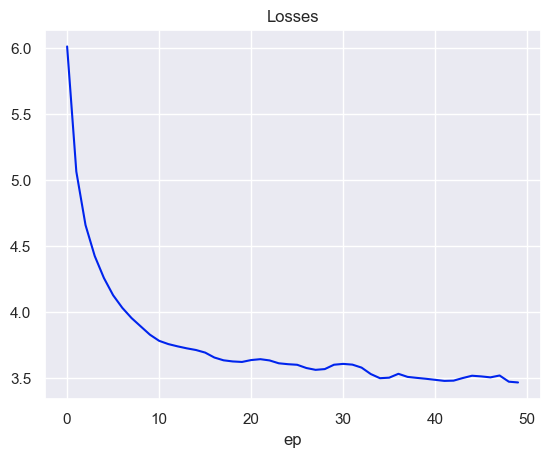

In [30]:
plt.plot(perplexities)
plt.title('Losses')
plt.xlabel('ep')
plt.show()

In [31]:
def generate(model, start_s, max_s_len):
    device = 'cpu'
    model.to(device)
    input_ids = [c2id['<bos>']] + [c2id.get(c, c2id['<unk>']) for c in start_s]
    input_ids = torch.LongTensor(input_ids).to(device)
    model.eval()
    with torch.no_grad():
        for i in range(max_s_len):
            next_c_dist = model(input_ids)[-1]
            next_c = next_c_dist.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_c.unsqueeze(0)])

            if next_c.item() == c2id['<eos>']:
                break
    words = ''.join([id2c[id_.item()] for id_ in  input_ids])
    return words
    

In [32]:
generate(model, start_s='гулял он как-то над ', max_s_len=128)

'<bos>гулял он как-то над ними привесть особой, от которого туда ж выводе - не прикажет.<eos>'

In [33]:
def text_generation(model, start_s, max_s_len, sent_num):
    crop_len = len(start_s)
    res = start_s
    start = start_s
    for i in range(sent_num):
        new = generate(model, start_s=start[-crop_len:], max_s_len=max_s_len)
        new = new.replace('<unk>', '').replace('<eos>', '').replace('<bos>', '')
        start = new[crop_len:]
        res += new[crop_len:]
    return res

In [34]:
text_generation(model, start_s='мороз и солнце', max_s_len=1024, sent_num=10)

'мороз и солнце от мертвная жизни нет и не слышала "а как же бы ни было, не смею спросить?.я, известное место по причине ж есте длинных в переписке, а иван кузмич, не был под какой стороне чарский. полк наш от магометанства, совершенно унивления. полк наш от магометанства, совершенно унивления. полк наш от магометанства, совершенно унивления.'

In [37]:
import pickle
torch.save(model.state_dict(), 'char_predicting 2 lstm 50 epochs')
with open('tokeniser.pkl', 'wb') as f:
    pickle.dump(c2id, f)